In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

# Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Data Encoding and Scaling
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn import set_config

# Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [3]:
warnings.filterwarnings('ignore')

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [5]:
df = pd.read_csv('extracted_data1.csv')

In [6]:
df.shape

(7672, 34)

In [7]:
df.drop(['subscription_type_y'], axis=1, inplace=True)

In [8]:
''' Filled all the null values before encoding the data '''

for col in df.columns:
    if df[col].dtype == np.int64:
        df[col].fillna(0, inplace=True)
    elif df[col].dtype == np.float64:
        df[col].fillna(0.0, inplace=True)
    elif df[col].dtype == object:
        df[col].fillna('Unknown', inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7672 entries, 0 to 7671
Data columns (total 33 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   jobma_catcher_id               7672 non-null   int64  
 1   org_type                       7672 non-null   object 
 2   jobma_catcher_industry         7672 non-null   object 
 3   jobma_catcher_type             7672 non-null   int64  
 4   is_premium                     7672 non-null   float64
 5   jobma_catcher_sub_accounts     7672 non-null   int64  
 6   jobma_catcher_is_deleted       7672 non-null   object 
 7   jobma_verified                 7672 non-null   int64  
 8   subscription_status            7672 non-null   int64  
 9   interview_rate                 7672 non-null   float64
 10  live_interview_credit          7672 non-null   float64
 11  pre_recorded_credit            7672 non-null   float64
 12  ai_live_interview_credit       7672 non-null   f

In [10]:
''' This Function is to fill all missing values (if col is int then 0, if col is float then 0.0 and if col is object then 'Unkmown') '''

def fill_missing_values(df):
    df = df.copy()
    for col in df.columns:
        if df[col].dtype == np.int64:
            df[col] = df[col].fillna(0)
        elif df[col].dtype == np.float64:
            df[col] = df[col].fillna(0.0)
        elif df[col].dtype == object:
            df[col] = df[col].fillna('Unknown')
    return df

# Data Encoding

In [12]:
label_encoders = {}
label_col = ['jobma_catcher_industry', 'org_type']

def label_encoder(df):
    for col in label_col:
        if col in df.columns:
            if df[col].dtype == object or df[col].dtype.name == 'category':
                le_col = LabelEncoder()
                df[col] = le_col.fit_transform(df[col].astype(str))
                label_encoders = le_col

    return df

In [13]:
def ordinal_encoder(df):
    ordinal_col = ['jobma_catcher_is_deleted', 'company_size', 'plan_type', 'is_unlimited']
    
    is_deleted_order = ['Yes', 'No']
    company_size_order = ['Unknown', '1-25', '26-100', '101-500', '500-1000', 'More than 1000']
    plan_type_order = ['Unknown', 'No', 'Yes']
    is_unlimited_order = ['Unknown', 'No', 'Yes']

    ordinal_order = [is_deleted_order, company_size_order, plan_type_order, is_unlimited_order]

    ordinal = OrdinalEncoder(categories=ordinal_order)
    encoded = ordinal.fit_transform(df[ordinal_col].astype(str))
    encoded_df = pd.DataFrame(encoded, columns=[f'{col}_ord' for col in ordinal_col], index=df.index)

    df.drop(columns=ordinal_col, inplace=True)

    df = pd.concat([df, encoded_df], axis=1)
    
    return df

# Pipeline

In [15]:
pipeline = Pipeline([
    ('fill_missing_values', FunctionTransformer(fill_missing_values, validate=False)),
    ('label_encoder', FunctionTransformer(label_encoder, validate=False)),
    ('ordinal_encoder', FunctionTransformer(ordinal_encoder, validate=False)),
    ('scaler', StandardScaler())# Needs attention to improve model
])

In [16]:
''' Visualizing the Pipeline '''
set_config(display='diagram')
pipeline

Pipeline(steps=[('fill_missing_values',
                 FunctionTransformer(func=<function fill_missing_values at 0x000001A214C57060>)),
                ('label_encoder',
                 FunctionTransformer(func=<function label_encoder at 0x000001A214CA47C0>)),
                ('ordinal_encoder',
                 FunctionTransformer(func=<function ordinal_encoder at 0x000001A214CA4B80>)),
                ('scaler', StandardScaler())])

# Data Splitting

In [18]:
X = df

In [19]:
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

In [20]:
print(f'Length of X_train: {len(X_train)}')
print(f'Length of X_test: {len(X_test)}')

Length of X_train: 6137
Length of X_test: 1535


In [21]:
type(X_train), type(X_test)

(pandas.core.frame.DataFrame, pandas.core.frame.DataFrame)

# Fit Pipeline

In [23]:
X_train_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.transform(X_test)

In [24]:
type(X_train), type(X_test)

(pandas.core.frame.DataFrame, pandas.core.frame.DataFrame)

In [25]:
type(X_train_transformed), type(X_test_transformed)

(numpy.ndarray, numpy.ndarray)

In [26]:
X_df = pd.DataFrame(X_train_transformed)

In [27]:
X_df.columns

RangeIndex(start=0, stop=33, step=1)

In [28]:
X_train_tensor = torch.tensor(X_train_transformed, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_transformed, dtype=torch.float32).to(device)

In [29]:
type(X_train_tensor), type(X_test_tensor)

(torch.Tensor, torch.Tensor)

In [30]:
len(X_train_tensor), len(X_test_tensor)

(6137, 1535)

# Dataset Class

In [32]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [33]:
train_data = CustomDataset(X_train_tensor)
test_data = CustomDataset(X_test_tensor)

# DataLoader

In [35]:
BATCH_SIZE = 15

In [36]:
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [37]:
len(train_data), len(test_data)

(6137, 1535)

In [38]:
len(train_dataloader), len(test_dataloader)

(410, 103)

# Autoencoder

In [40]:
class AutoEncoder(nn.Module):
    def __init__(self, input_shape):
        super().__init__()
        ''' Encoder (Compression) '''
        # Shrinks job data into a small hidden representation (like a summary).
        self.encoder = nn.Sequential(
            nn.Linear(input_shape, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )

        ''' Decoder (Reconstruction) '''
        # Tries to rebuild the original job data from that compressed version.
        self.decoder = nn.Sequential(
            nn.Linear(32,64),
            nn.ReLU(),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128, input_shape)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [41]:
X_df.shape[1]

33

In [42]:
''' Initializing the model '''
input_shape = X_df.shape[1]

model_1 = AutoEncoder(input_shape)
model_1.to(device)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=33, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=33, bias=True)
  )
)

In [43]:
''' Important Parameters '''

learning_rate = 0.001
epochs = 20

In [44]:
''' Loss Function and Optimizer '''

cosine_loss_function = nn.CosineEmbeddingLoss()
mse_loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=learning_rate)

In [45]:
model_1.train()
model_1.to(device)

for epoch in range(epochs):
    epoch_total_loss = 0

    for batch_X in train_dataloader:
        batch_X = batch_X.to(device)

        # Forward pass
        encoded, decoded = model_1(batch_X)

        # Reconstruction Loss
        mse_loss = mse_loss_function(decoded, batch_X)

        # Similarity Loss using randomly shuffled batch
        batch_size = encoded.shape[0]
        target_labels = torch.ones(batch_size, device=device)

        permuted_indices = torch.randperm(batch_size, device=device)
        encoded_shuffled = encoded[permuted_indices]

        cosine_loss = cosine_loss_function(encoded, encoded_shuffled, target_labels)

        # Total Loss
        total_loss = mse_loss + cosine_loss

        # Backpropagation
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        epoch_total_loss += total_loss.item()

    # Average loss over all batches in the epoch
    training_loss = epoch_total_loss / len(train_dataloader)
    print(f'Epoch {epoch+1}/{epochs} | Training Loss: {training_loss:.5f}')


Epoch 1/20 | Training Loss: 0.82740
Epoch 2/20 | Training Loss: 0.64278
Epoch 3/20 | Training Loss: 0.56541
Epoch 4/20 | Training Loss: 0.52649
Epoch 5/20 | Training Loss: 0.46534
Epoch 6/20 | Training Loss: 0.40563
Epoch 7/20 | Training Loss: 0.36706
Epoch 8/20 | Training Loss: 0.35455
Epoch 9/20 | Training Loss: 0.28213
Epoch 10/20 | Training Loss: 0.26767
Epoch 11/20 | Training Loss: 0.31981
Epoch 12/20 | Training Loss: 0.25899
Epoch 13/20 | Training Loss: 0.20729
Epoch 14/20 | Training Loss: 0.17291
Epoch 15/20 | Training Loss: 0.20290
Epoch 16/20 | Training Loss: 0.24355
Epoch 17/20 | Training Loss: 0.22409
Epoch 18/20 | Training Loss: 0.18923
Epoch 19/20 | Training Loss: 0.17747
Epoch 20/20 | Training Loss: 0.13923


# Clustering

In [48]:
model_1.eval()

with torch.no_grad():
    encoder, _ = model_1(X_train_tensor)

latent_np = encoder.cpu().numpy()

In [50]:
wcss = []
silhouette_scores = []
k_range = range(2,11)

In [52]:
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(latent_np)
    
    wcss.append(kmeans.inertia_)  # Inertia = WCSS
    silhouette_scores.append(silhouette_score(latent_np, labels))

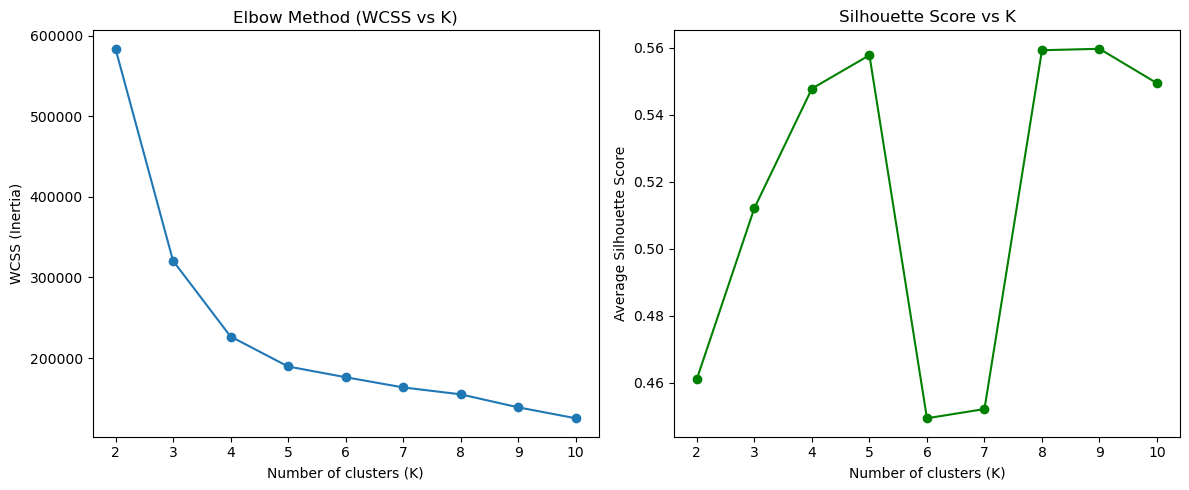

In [53]:
''' Elbow Rule to decide the number of clusters '''

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, wcss, marker='o')
plt.title('Elbow Method (WCSS vs K)')
plt.xlabel('Number of clusters (K)')
plt.ylabel('WCSS (Inertia)')

# Step 5: Plot Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o', color='green')
plt.title('Silhouette Score vs K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Average Silhouette Score')

plt.tight_layout()
plt.show()

In [56]:
#Initialising KMeans
kmeans = KMeans(n_clusters=4, n_init=20)
cluster_ids = kmeans.fit_predict(latent_np)
cluster_centers = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32).to(device)

In [60]:
# Deep Embedding Clusturing Model
class DEC(nn.Module):
    def __init__(self, encoder, cluster_centers):
        super(DEC, self).__init__()
        self.encoder = encoder
        self.cluster_centers = nn.Parameter(cluster_centers)

    def forward(self, x):
        z = self.encoder(x)
        q = 1.0 / (1.0 + torch.sum((z.unsqueeze(1) - self.cluster_centers)**2, dim=2))
        q = q.pow((1 + 1) / 2.0)
        q = (q.t() / torch.sum(q, dim=1)).t()
        return q, z

def target_distribution(q):
    weight = q**2 / q.sum(0)
    return (weight.t() / weight.sum(1)).t()  

#Train DEC
dec = DEC(model_1.encoder, cluster_centers.clone()).to(device)
optimizer = torch.optim.Adam(dec.parameters(), lr=1e-3)

In [66]:
kl_loss = nn.KLDivLoss(reduction='batchmean')

In [70]:
from torch.nn import functional as F

dec.train()
num_epochs = 20  # or however long you want

for epoch in range(num_epochs):
    for batch in train_dataloader:  # assuming you have a DataLoader set up
        x = batch.to(device)

        # Forward pass
        q, z = dec(x)

        # Target distribution
        p = target_distribution(q)

        # Compute loss
        loss = F.kl_div(q.log(), p, reduction='batchmean')

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Optional: Print progress
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}")

Epoch 1/20, Loss: 0.0452
Epoch 2/20, Loss: 0.0004
Epoch 3/20, Loss: 0.0078
Epoch 4/20, Loss: 0.0000
Epoch 5/20, Loss: 0.0107
Epoch 6/20, Loss: 0.0000
Epoch 7/20, Loss: 0.0002
Epoch 8/20, Loss: 0.0000
Epoch 9/20, Loss: 0.0049
Epoch 10/20, Loss: 0.0039
Epoch 11/20, Loss: 0.0000
Epoch 12/20, Loss: 0.0015
Epoch 13/20, Loss: 0.0000
Epoch 14/20, Loss: 0.0028
Epoch 15/20, Loss: 0.0102
Epoch 16/20, Loss: 0.0000
Epoch 17/20, Loss: 0.0025
Epoch 18/20, Loss: 0.0081
Epoch 19/20, Loss: 0.0000
Epoch 20/20, Loss: 0.0023
